# Multi- time series training and covariates

This notebook serves as a tutorial for:
* Training a model with several time series
* Training a model using covariates

### /WIP\ This notebook is not yet complete /WIP\

Note that we'll not do any sort of hyper-parameter tuning here - the goal won't be to obtain the very best accuracy, but rather to showcase how the models can be used.

In [1]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import matplotlib.pyplot as plt

### Read Data:
Let's start by reading one time series:

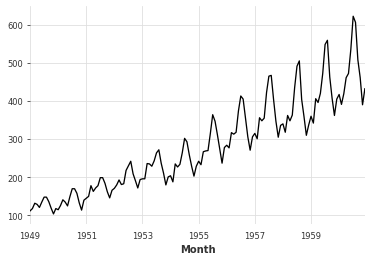

In [2]:
df = pd.read_csv('AirPassengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', ['#Passengers'])
series.plot()

## Generate Time Series we'll use for training and evaluation:
We scale the original series between 0 and 1 and get two noisy variants. We'll then use these variants as a sort of data augmentation for training models on several time series.

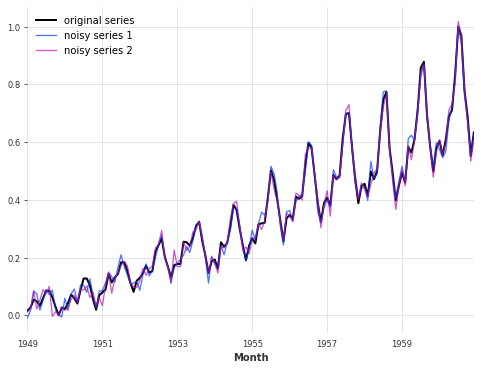

In [3]:
scaler = Scaler()
series_tr = scaler.fit_transform(series)

# Generate two noisy versions of the original series:
noise1 = 0.02 * gaussian_timeseries(length=len(series_tr), freq=series_tr.freq_str(), start_ts=series_tr.start_time())
noise2 = 0.02 * gaussian_timeseries(length=len(series_tr), freq=series_tr.freq_str(), start_ts=series_tr.start_time())

series1_tr = series_tr + noise1
series2_tr = series_tr + noise2

plt.figure(figsize=(8,6))
series_tr.plot(label='original series', lw=2)
series1_tr.plot(label='noisy series 1', alpha=0.7)
series2_tr.plot(label='noisy series 2', alpha=0.7)
plt.legend();

### Split in train and validation sets:

In [4]:
series_train, series_val = series_tr[:-36], series_tr[-36:]
series1_train, series1_val = series1_tr[:-36], series1_tr[-36:]
series2_train, series2_val = series2_tr[:-36], series2_tr[-36:]

## Multi series training
Below, we'll train a model with our two noisy series (without covariates), and see how it impacts accuracy compared to training on one series only.

First, we write a helper function that we'll use to build an LSTM model throughout the notebook:

In [5]:
def build_rnn_model(in_len, out_len, in_size, out_size, n_epochs=200):
    return RNNModel(
        model='LSTM',
        input_length=in_len,
        output_length=out_len,
        input_size=in_size,
        output_size=out_size,
        hidden_size=25,
        n_rnn_layers=1,
        batch_size=16,
        n_epochs=n_epochs
    )

Then, we can build a model. Note that below we'll build a model using `input_size=1` and `output_size=1`, because the dimensionality of the target time series is 1. Later we will use covariates in input, which will increase the input dimensionality. 

We make the choice to train the model to predict the next 12 points (`output_length`), always looking at the 24 preceding points (`input_length`).

Now, fitting the model on two (or several) time series can be as simple as providing a list of time series arguments to the `fit()` function:

In [6]:
model_multi_ts = build_rnn_model(in_len=24, out_len=12, in_size=1, out_size=1, n_epochs=100)
model_multi_ts.fit([series_train, series1_train, series2_train], verbose=True)

[2020-12-23 16:09:27,222] INFO | darts.models.torch_forecasting_model | Train dataset contains 219 samples.
[2020-12-23 16:09:27,222] INFO | darts.models.torch_forecasting_model | Train dataset contains 219 samples.


Training loss: 0.0042


Note: If you are working on bigger datasets that do not fit in memory, you can provide another `Sequence` type than list. In particular, you can define your own loader class (extending `Sequence`), implementing only the `__len__()` and `__item__()` functions, and loading data and building `TimeSeries` on the fly.

We now train a similar model, but only on one of the two time series:

In [7]:
model_single_ts = build_rnn_model(in_len=24, out_len=12, in_size=1, out_size=1, n_epochs=300)
model_single_ts.fit(series_train, verbose=True)

[2020-12-23 16:10:46,397] INFO | darts.models.torch_forecasting_model | Train dataset contains 73 samples.
[2020-12-23 16:10:46,397] INFO | darts.models.torch_forecasting_model | Train dataset contains 73 samples.


Training loss: 0.0017


Let's see how both models perform. Note that we'll get predictions using `predict()` for time horizons of 36 (the length of the validation set). This is larger than the `output_length` of our LSTM models (which is 12); but this is not an issue because when no covariates are used. The `predict()` function will just iteratively produce and concatenate the length-12 outputs of the LSTM models until it obtains 36 points.

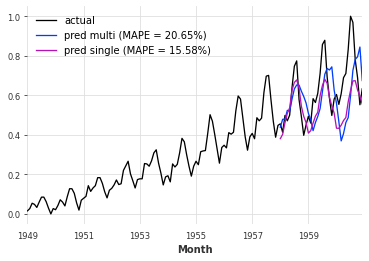

In [8]:
pred_multi = model_multi_ts.predict(len(series_val), series_train)
pred_single = model_single_ts.predict(len(series_val), series_train)

series_tr.plot(label='actual')
pred_multi.plot(label='pred multi (MAPE = {:.2f}%)'.format(mape(series_tr, pred_multi)))
pred_single.plot(label='pred single (MAPE = {:.2f}%)'.format(mape(series_tr, pred_single)))
plt.legend();

There is no big performance difference in this case when using the additional noisy time series; none of the two models performs particularly well.

Let's see how the models work in backtesting conditions:

In [9]:
hist_pred_multi = model_multi_ts.historical_forecasts(series_tr, 
                                                      start=0.7, 
                                                      forecast_horizon=12, 
                                                      stride=1,
                                                      retrain=False,
                                                      verbose=True)

hist_pred_single = model_single_ts.historical_forecasts(series_tr, 
                                                        start=0.7, 
                                                        forecast_horizon=12, 
                                                        stride=1,
                                                        retrain=False,
                                                        verbose=True)

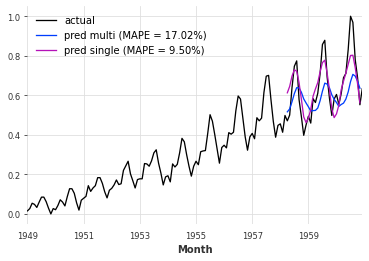

In [10]:
series_tr.plot(label='actual')
hist_pred_multi.plot(label='pred multi (MAPE = {:.2f}%)'.format(mape(hist_pred_multi, series_tr)))
hist_pred_single.plot(label='pred single (MAPE = {:.2f}%)'.format(mape(hist_pred_single, series_tr)))
plt.legend();

None of the two version works very well. Let's see if we can do better using covariates.

## Using Covariates
To try improving the forecast performance, we'll use fairly straigthforward time series containing the year and the month. 
To this end, we generate *one* multivariate time series containing *two* dimensions: one dimension contains the year and the other contains the month.

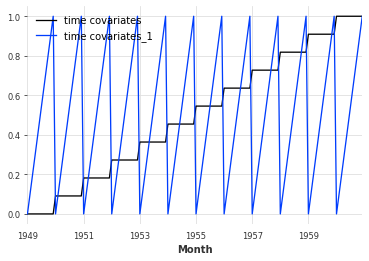

In [13]:
year_series = datetime_attribute_timeseries(series_tr, attribute='year')
month_series = datetime_attribute_timeseries(series_tr, attribute='month')

scaler_dt = Scaler()
time_covariates = scaler_dt.fit_transform(year_series.stack(month_series))

time_covariates_train, time_covariates_val = time_covariates[:-36], time_covariates[-36:]

plt.figure(figsize=(6,4))
time_covariates.plot(label='time covariates')
plt.legend();

In what follows, we'll limit ourselves to a forecast horizon of 12. When using covariates, we cannot call `predict()` with a horizon value `n` larger than the value of the model output length (this is because covariates would be required to produce auto-regressive outputs).

The model with covariates will have an input size of 3: 1 dimension for the target and 2 dimensions for the covariates:

In [14]:
model_cov = build_rnn_model(in_len=24, out_len=12, in_size=3, out_size=1, n_epochs=300)
model_cov.fit(series_train, covariates=time_covariates_train, verbose=True)

[2020-12-23 16:14:42,250] INFO | darts.models.torch_forecasting_model | Train dataset contains 73 samples.
[2020-12-23 16:14:42,250] INFO | darts.models.torch_forecasting_model | Train dataset contains 73 samples.


Training loss: 0.0011


As a comparison, we also train a model without covariates:

In [15]:
model_no_cov = build_rnn_model(in_len=24, out_len=12, in_size=1, out_size=1, n_epochs=300)
model_no_cov.fit(series_train, verbose=True)

[2020-12-23 16:16:18,264] INFO | darts.models.torch_forecasting_model | Train dataset contains 73 samples.
[2020-12-23 16:16:18,264] INFO | darts.models.torch_forecasting_model | Train dataset contains 73 samples.


Training loss: 0.0039


In [16]:
pred_cov = model_cov.predict(n=12, series=series_train, covariates=time_covariates_train)
pred_no_cov = model_no_cov.predict(n=12, series=series_train)

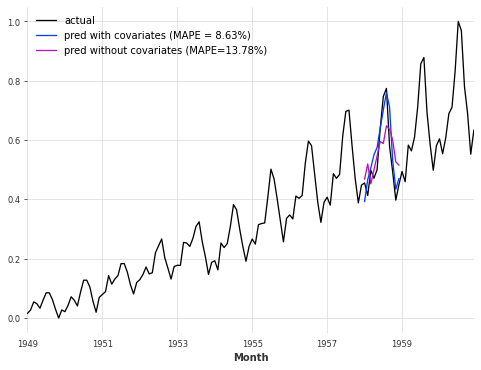

In [17]:
from darts.metrics import mape
plt.figure(figsize=(8,6))
series_tr.plot(label='actual')
pred_cov.plot(label='pred with covariates (MAPE = {:.2f}%)'.format(mape(pred_cov, series_tr)))
pred_no_cov.plot(label='pred without covariates (MAPE={:.2f}%)'.format(mape(pred_no_cov, series_tr)))
plt.legend();

### Backtesting with covariates
Darts supports backtesting with covariates, it works like this:

In [18]:
pred_cov = model_cov.historical_forecasts(series_tr,
                                          covariates=time_covariates,
                                          start=0.75,
                                          forecast_horizon=12,
                                          stride=1,
                                          retrain=False,
                                          verbose=True)

pred_no_cov = model_no_cov.historical_forecasts(series_tr, 
                                                start=0.75,
                                                forecast_horizon=12, 
                                                stride=1,
                                                retrain=False,
                                                verbose=True)

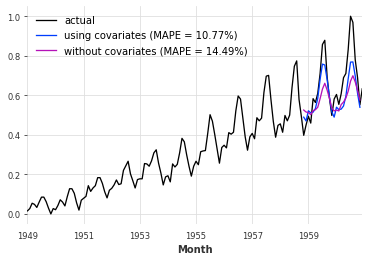

In [20]:
series_tr.plot(label='actual')
pred_cov.plot(label='using covariates (MAPE = {:.2f}%)'.format(mape(series_tr, pred_cov)))
pred_no_cov.plot(label='without covariates (MAPE = {:.2f}%)'.format(mape(series_tr, pred_no_cov)))
plt.legend()

## Tying it together: training with multiple time series and covariates
This is easy, we can just provide our 3 target time series for fitting, and the corresponding covariates. We just have to be mindful here to provide one covariate time series per target time series - so we repeat the covariates 3 times:

In [21]:
model_final = build_rnn_model(in_len=24, out_len=12, in_size=3, out_size=1, n_epochs=100)

model_final.fit([series_train, series1_train, series2_train], 
                 covariates=[time_covariates_train for _ in range(3)], 
                 verbose=True)

[2020-12-23 16:27:21,671] INFO | darts.models.torch_forecasting_model | Train dataset contains 219 samples.
[2020-12-23 16:27:21,671] INFO | darts.models.torch_forecasting_model | Train dataset contains 219 samples.


Training loss: 0.0008


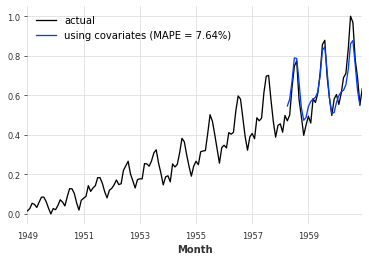

In [22]:
pred_final = model_final.historical_forecasts(series_tr,
                                              covariates=time_covariates,
                                              start=0.7,
                                              forecast_horizon=12,
                                              retrain=False,
                                              verbose=True)

series_tr.plot(label='actual')
pred_final.plot(label='using covariates (MAPE = {:.2f}%)'.format(mape(series_tr, pred_final)))
plt.legend()

## Experiment with other models
### Transformer

In [23]:
def build_transformer_model(in_len, out_len, in_size, out_size, n_epochs=200):
    return TransformerModel(
        input_length=in_len,
        output_length=out_len,
        input_size=in_size,
        output_size=out_size,
        d_model = 64,
        nhead = 32,
        num_encoder_layers = 3,
        num_decoder_layers = 3,
        dim_feedforward = 64,
        batch_size=16,
        n_epochs=n_epochs
    )

In [24]:
model_transformer = build_transformer_model(in_len=24, out_len=12, in_size=3, out_size=1, n_epochs=100)

model_transformer.fit([series_train, series1_train, series2_train], 
                      covariates=[time_covariates_train for _ in range(3)], 
                      verbose=True)

[2020-12-23 16:28:57,131] INFO | darts.models.torch_forecasting_model | Train dataset contains 219 samples.
[2020-12-23 16:28:57,131] INFO | darts.models.torch_forecasting_model | Train dataset contains 219 samples.


Training loss: 0.0015


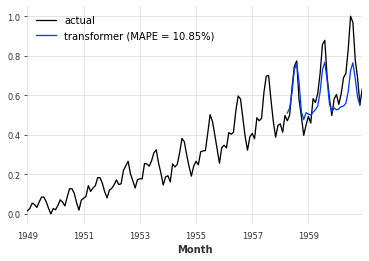

In [25]:
pred_transformer = model_transformer.historical_forecasts(series_tr,
                                                          covariates=time_covariates,
                                                          start=0.7,
                                                          forecast_horizon=12,
                                                          retrain=False,
                                                          verbose=True)

series_tr.plot(label='actual')
pred_transformer.plot(label='transformer (MAPE = {:.2f}%)'.format(mape(series_tr, pred_transformer)))
plt.legend()

### (For comparison) using only one time series and no covariates

In [26]:
model_transformer_s = build_transformer_model(in_len=24, out_len=12, in_size=1, out_size=1, n_epochs=100)

model_transformer_s.fit(series_train, verbose=True)

[2020-12-23 16:31:18,957] INFO | darts.models.torch_forecasting_model | Train dataset contains 73 samples.
[2020-12-23 16:31:18,957] INFO | darts.models.torch_forecasting_model | Train dataset contains 73 samples.


Training loss: 0.0093


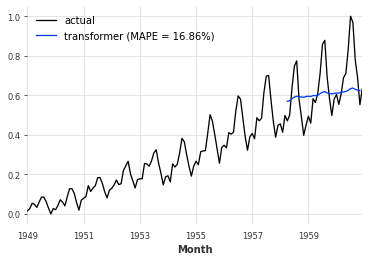

In [27]:
pred_transformer_s = model_transformer_s.historical_forecasts(series_tr,
                                                              start=0.7,
                                                              forecast_horizon=12,
                                                              retrain=False,
                                                              verbose=True)

series_tr.plot(label='actual')
pred_transformer_s.plot(label='transformer (MAPE = {:.2f}%)'.format(mape(series_tr, pred_transformer_s)))
plt.legend()

### TCN

In [28]:
def build_tcn_model(in_len, out_len, in_size, out_size, n_epochs=200):
    return TCNModel(
        input_length=in_len,
        output_length=out_len,
        input_size=in_size,
        output_size=out_size,
        n_epochs=n_epochs
    )

In [29]:
tcn_model = build_tcn_model(in_len=24, out_len=12, in_size=3, out_size=1, n_epochs=200)
tcn_model.fit([series_train, series1_train, series2_train], 
              covariates=[time_covariates_train for _ in range(3)], 
              verbose=True)

[2020-12-23 16:31:57,140] INFO | darts.models.tcn_model | Number of layers chosen: 3
[2020-12-23 16:31:57,140] INFO | darts.models.tcn_model | Number of layers chosen: 3
[2020-12-23 16:31:57,163] INFO | darts.models.torch_forecasting_model | Train dataset contains 252 samples.
[2020-12-23 16:31:57,163] INFO | darts.models.torch_forecasting_model | Train dataset contains 252 samples.


Training loss: 0.0058


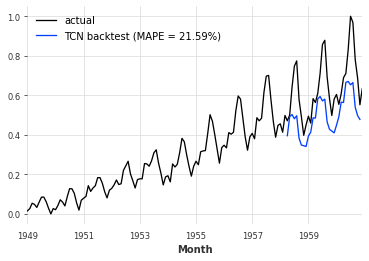

In [33]:
bt_tcn = tcn_model.historical_forecasts(series_tr,
                                        covariates=time_covariates,
                                        start=0.7,
                                        forecast_horizon=12,
                                        retrain=False,
                                        verbose=True)

series_tr.plot(label='actual')
bt_tcn.plot(label='TCN backtest (MAPE = {:.2f}%)'.format(mape(series_tr, bt_tcn)))
plt.legend()

### N-Beats
The (current implementation of) N-Beats model supports only univariate time series, and thus we cannot use covariates. Let's still see how it would go to train an instance of the N-Beats model on several time series:

In [34]:
def build_nbeats_model(in_len, out_len, n_epochs=200):
    return NBEATSModel(
        input_length=in_len,
        output_length=out_len,
        num_stacks=10,
        num_blocks=1,
        num_layers=3,
        layer_widths=25,
        n_epochs=n_epochs
    )

In [35]:
nbeats_model = build_nbeats_model(in_len=24, out_len=12, n_epochs=200)
nbeats_model.fit([series_train, series1_train, series2_train], verbose=True)

[2020-12-23 16:35:53,381] INFO | darts.models.torch_forecasting_model | Train dataset contains 219 samples.
[2020-12-23 16:35:53,381] INFO | darts.models.torch_forecasting_model | Train dataset contains 219 samples.


Training loss: 0.0007


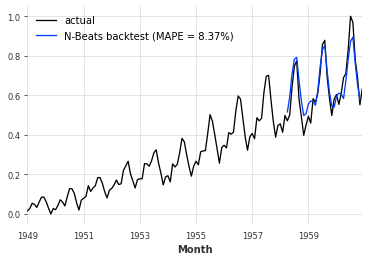

In [36]:
bt_nbeats = nbeats_model.historical_forecasts(series_tr,
                                              start=0.7,
                                              forecast_horizon=12,
                                              retrain=False,
                                              verbose=True)

series_tr.plot(label='actual')
bt_nbeats.plot(label='N-Beats backtest (MAPE = {:.2f}%)'.format(mape(series_tr, bt_nbeats)))
plt.legend()